In [1]:
import math
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from keras.regularizers import l1, l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import Sequential, Model
from keras.layers import LSTM, Dense, Input, Dropout, Attention, Concatenate
from scikeras.wrappers import KerasRegressor

In [2]:
#scrap dataset
ticker = 'AAPL'
stockPrices = yf.download(ticker, '1981-01-01', '2024-07-14')

[*********************100%%**********************]  1 of 1 completed


In [3]:
# stockPrices = pd.read_csv('AAPL.csv')

### EDA

In [4]:
stockPrices.isnull()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-01-02,False,False,False,False,False,False
1981-01-05,False,False,False,False,False,False
1981-01-06,False,False,False,False,False,False
1981-01-07,False,False,False,False,False,False
1981-01-08,False,False,False,False,False,False
...,...,...,...,...,...,...
2024-07-08,False,False,False,False,False,False
2024-07-09,False,False,False,False,False,False
2024-07-10,False,False,False,False,False,False


In [5]:
stockPrices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10973 entries, 1981-01-02 to 2024-07-12
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       10973 non-null  float64
 1   High       10973 non-null  float64
 2   Low        10973 non-null  float64
 3   Close      10973 non-null  float64
 4   Adj Close  10973 non-null  float64
 5   Volume     10973 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 600.1 KB


In [6]:
stockPrices.dtypes

Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [7]:
stockPrices.shape

(10973, 6)

In [8]:
stockPrices.size

65838

In [9]:
stockPrices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,10973.000000,10973.000000,10973.000000,10973.000000,10973.000000,1.097300e+04
mean,22.103272,22.342210,21.875797,22.118593,21.323443,3.186282e+08
std,45.556227,46.048883,45.104021,45.598242,45.166691,3.356133e+08
min,0.049665,0.049665,0.049107,0.049107,0.037900,0.000000e+00
25%,0.299107,0.304821,0.291295,0.299107,0.242615,1.136056e+08
50%,0.531250,0.537946,0.522321,0.531250,0.432579,2.061528e+08
75%,20.136429,20.328215,19.940357,20.101070,17.246332,3.990028e+08
max,231.389999,233.080002,229.250000,232.979996,232.979996,7.421641e+09


In [10]:
stockPrices.isna()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1981-01-02,False,False,False,False,False,False
1981-01-05,False,False,False,False,False,False
1981-01-06,False,False,False,False,False,False
1981-01-07,False,False,False,False,False,False
1981-01-08,False,False,False,False,False,False
...,...,...,...,...,...,...
2024-07-08,False,False,False,False,False,False
2024-07-09,False,False,False,False,False,False
2024-07-10,False,False,False,False,False,False


### Train-test Split

In [11]:
# Split ratio
testRatio = 0.2
trainingRatio = 1 - testRatio

In [12]:
trainingSize = int(trainingRatio * len(stockPrices))
testSize = int(testRatio * len(stockPrices))
print(f"Training Size: {trainingSize}")
print(f"Testing Size: {testSize}")

Training Size: 8778
Testing Size: 2194


In [13]:
train = stockPrices[:trainingSize][["Close"]]
test = stockPrices[trainingSize:][["Close"]].copy()

In [14]:
## Split the time-series data into training seq X and output value Y
def extract_seqX_outcomeY(data, N, offset):
    X, y = [], []
    for i in range(offset, len(data)):
        X.append(data[i - N: i])
        y.append(data[i])
    return np.array(X), np.array(y)

### RMSE and MAPE

In [15]:
# Calculate the metrics RMSE and MAPE
def calculateRMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

def calculateMAPE(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [16]:
def calculate_perf_metrics(var):
    rmse = calculateRMSE(
        np.array(stockPrices[trainingSize:]["Close"]),
        np.array(stockPrices[trainingSize:][var]),
    )
    mape = calculateMAPE(
        np.array(stockPrices[trainingSize:]["Close"]),
        np.array(stockPrices[trainingSize:][var]),
    )
    return rmse, mape

In [17]:
def plot_stock_trend(var, cur_title, stockprices=stockPrices):
    ax = stockprices[["Close", var, "200 Days"]].plot(figsize=(20, 10))
    plt.grid(False)
    plt.title(cur_title)
    plt.axis("tight")
    plt.ylabel("Stock Price ($)")

### SMA

RMSE for SMA: 7.9433178440708625
MAPE for SMA: 6.060198986610777


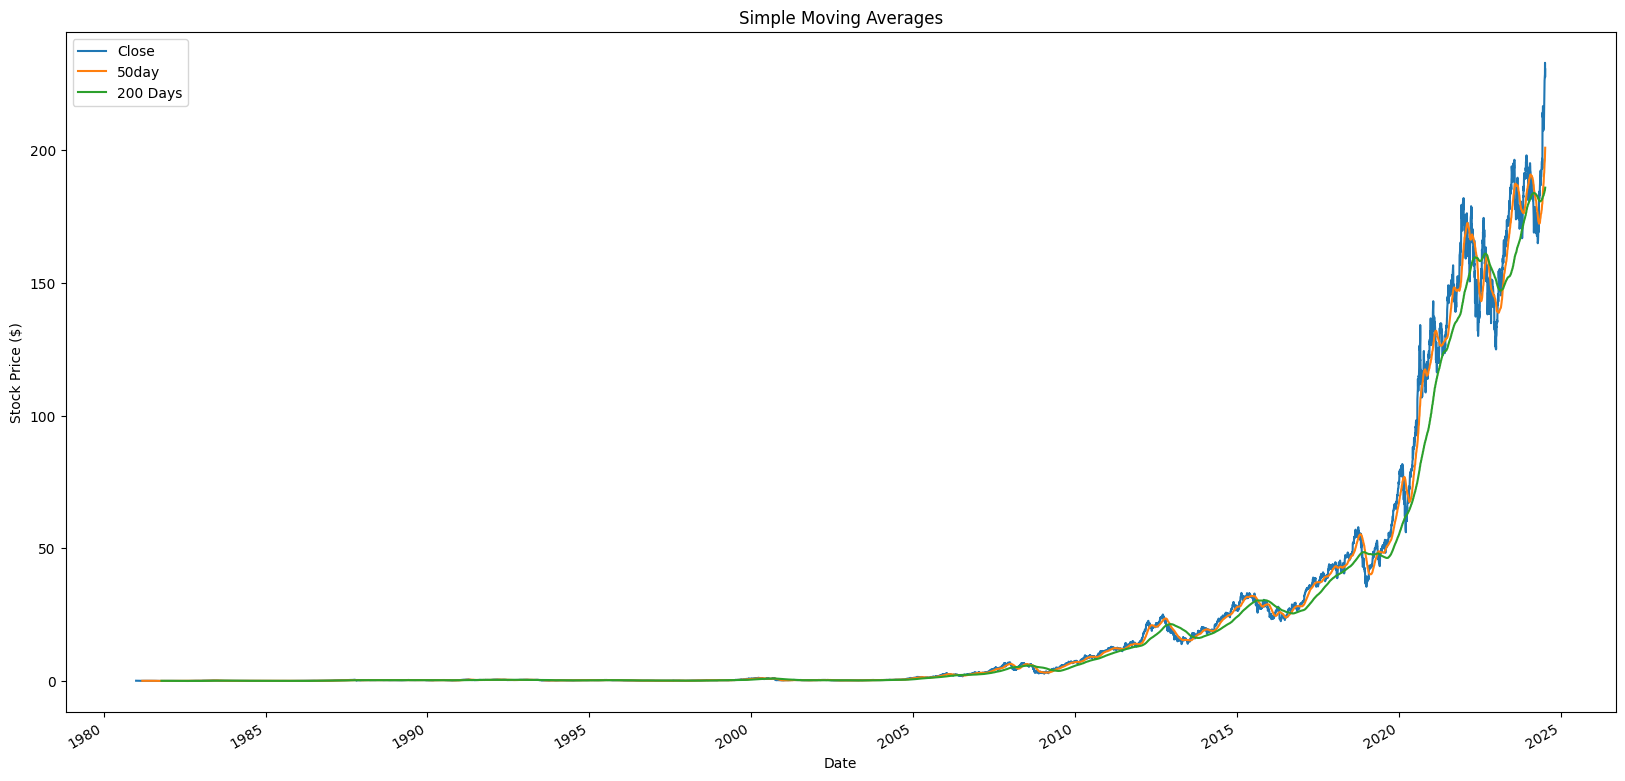

In [18]:
window_size = 50
window_var = f"{window_size}day"
stockPrices[window_var] = stockPrices["Close"].rolling(window_size).mean()
stockPrices["200 Days"] = stockPrices["Close"].rolling(200).mean()

# Plot and performance metrics for SMA model
plot_stock_trend(var=window_var, cur_title="Simple Moving Averages")
rmse_sma, mape_sma = calculate_perf_metrics(var=window_var)

print(f"RMSE for SMA: {rmse_sma}")
print(f"MAPE for SMA: {mape_sma}")

### EMA

RMSE for EMA: 6.68008416375648
MAPE for EMA: 5.089289013234137


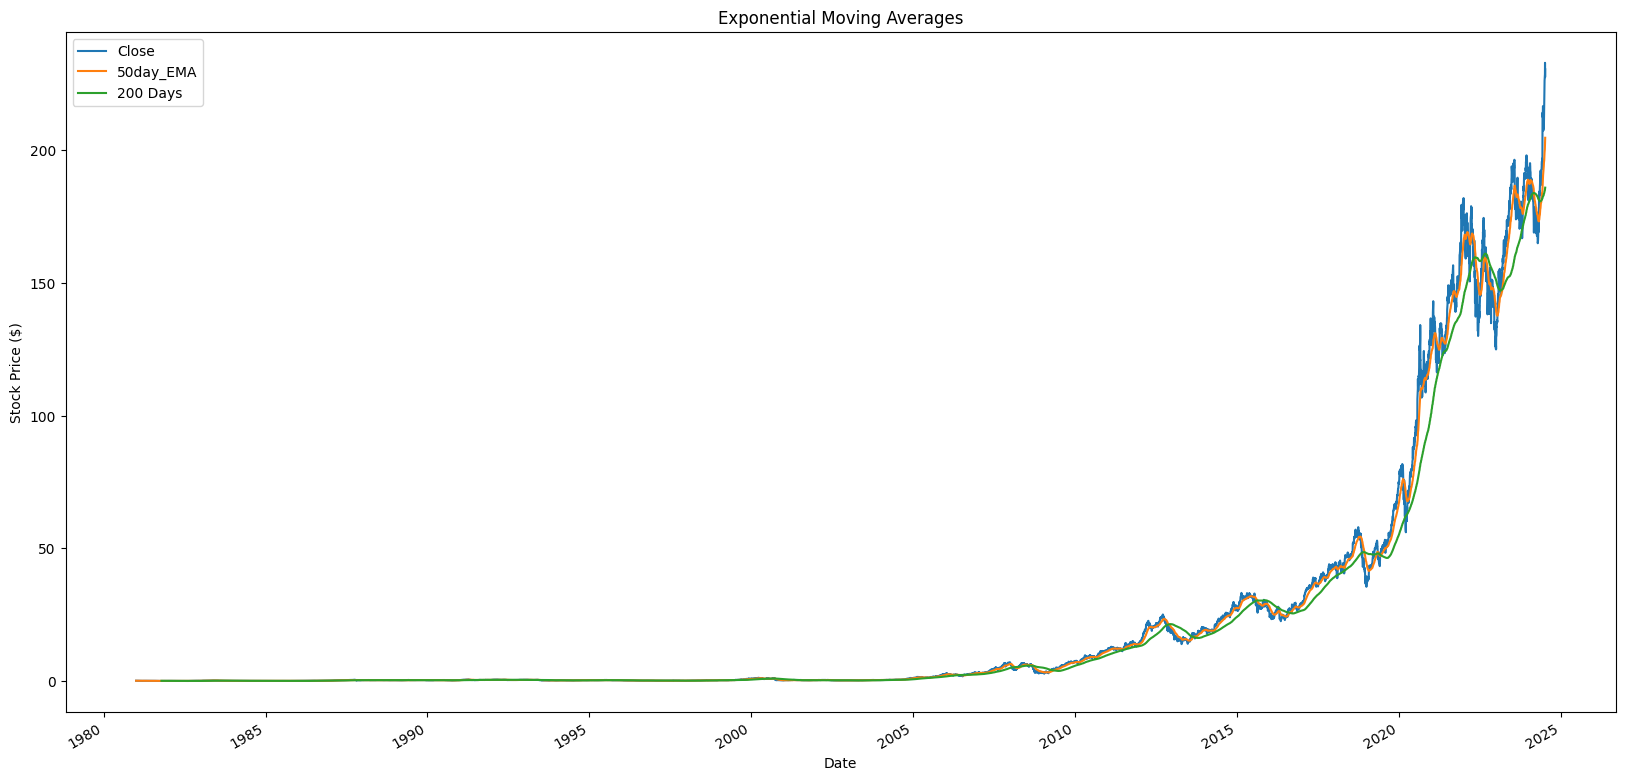

In [19]:
window_ema_var = f"{window_var}_EMA"
stockPrices[window_ema_var] = (
    stockPrices["Close"].ewm(span=window_size, adjust=False).mean()
)
stockPrices["200 Days"] = stockPrices["Close"].rolling(200).mean()

# Plot and performance metrics for EMA model
plot_stock_trend(
    var=window_ema_var, cur_title="Exponential Moving Averages")
rmse_ema, mape_ema = calculate_perf_metrics(var=window_ema_var)

print(f"RMSE for EMA: {rmse_ema}")
print(f"MAPE for EMA: {mape_ema}")

### LSTM 

In [20]:
warnings.filterwarnings("ignore", category=UserWarning, module='sklearn')

# Scale dataset
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stockPrices[["Close"]])
scaled_data_train = scaled_data[:train.shape[0]]

window_size = 50
X_train, y_train = extract_seqX_outcomeY(scaled_data_train, window_size, window_size)

# Ensure data is in the correct format
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')

In [21]:
# Reshape X_train if necessary (for LSTM input)
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("After preprocessing:")
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)

After preprocessing:
X_train shape: (8728, 50, 1)
X_train dtype: float32
y_train shape: (8728, 1)
y_train dtype: float32


In [22]:
# Ensure data is in the correct format
X_train = np.array(X_train).astype('float32')
y_train = np.array(y_train).astype('float32')

# Reshape X_train if necessary (for LSTM input)
if len(X_train.shape) == 2:
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

print("After preprocessing:")
print("X_train shape:", X_train.shape)
print("X_train dtype:", X_train.dtype)
print("y_train shape:", y_train.shape)
print("y_train dtype:", y_train.dtype)

After preprocessing:
X_train shape: (8728, 50, 1)
X_train dtype: float32
y_train shape: (8728, 1)
y_train dtype: float32


In [23]:
def create_model(layer_units=95, dropout_rate=0.2, recurrent_dropout_rate=0.1, optimizer='adam'):
    input_shape = (X_train.shape[1], 1) if len(X_train.shape) == 2 else (X_train.shape[1], X_train.shape[2])
    inputs = Input(shape=input_shape)
    lstm_out = LSTM(units=layer_units, return_sequences=True, 
                    dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)(inputs)
    lstm_out = LSTM(units=layer_units, return_sequences=True, 
                    dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)(lstm_out)
    attention = Attention()([lstm_out, lstm_out])
    combined = Concatenate()([lstm_out, attention])
    final_lstm = LSTM(units=layer_units, 
                      dropout=dropout_rate, recurrent_dropout=recurrent_dropout_rate)(combined)
    outputs = Dense(1)(final_lstm)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss="mean_squared_error", optimizer=optimizer)
    return model

In [24]:
model = KerasRegressor(
    model=create_model,
    layer_units=50,
    dropout_rate=0.3,
    recurrent_dropout_rate=0.1,
    optimizer='adam',
    batch_size=32,
    epochs=50,
    verbose=1  
)

### Hyperparameter Tuning

In [25]:
param_grid = {
    'layer_units': [50, 64, 95],
    'dropout_rate': [0.1],
    'recurrent_dropout_rate': [0.2, 0.3],
    'batch_size': [128],
    'epochs': [20, 30, 50],
}

In [26]:
try:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, verbose=1)
    grid_result = grid.fit(X_train, y_train)
    print("Best parameters found: ", grid_result.best_params_)
    print("Best score: ", grid_result.best_score_)
except Exception as e:
    print(f"An error occurred: {str(e)}")
    print("Error type:", type(e))
    print("Error args:", e.args)
    import traceback
    traceback.print_exc()

Fitting 3 folds for each of 18 candidates, totalling 54 fits
Epoch 1/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 11s 88ms/step - loss: 0.0343
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0126
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0116
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0121
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0125
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0108
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0114
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0114
Epoch 9/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0111
Epoch 10/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0105
Epoch 11/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0085
Epoch 12/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0054
Epoch 13/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0049
Epoch 14/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.0055
Epoch 15/

In [27]:
best_params = {k.replace('model__', ''): v for k, v in grid_result.best_params_.items()}
print("Best parameters found: ", best_params)

Best parameters found:  {'batch_size': 128, 'dropout_rate': 0.1, 'epochs': 30, 'layer_units': 64, 'recurrent_dropout_rate': 0.3}


In [28]:
final_model = create_model(
    layer_units=best_params['layer_units'],
    dropout_rate=best_params['dropout_rate'],
    recurrent_dropout_rate=best_params['recurrent_dropout_rate'],
    optimizer='adam'
)

In [29]:
final_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 50, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50, 64)    │     16,896 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 50, 64)    │     33,024 │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_1         │ (None, 50, 64)    │          0 │ lstm_4[0][0],     │
│ (Attention)         │                   │            │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 50, 128)   │          0 │ lstm_4[0][0],     │
│ (Concatenate)       │                   │            │ attention_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 64)        │     49,408 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         65 │ lstm_5[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 99,393 (388.25 KB)

 Trainable params: 99,393 (388.25 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_v5.keras', monitor='val_loss', save_best_only=True)

In [31]:
history = final_model.fit(
    X_train,
    y_train,
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    validation_split=0.2,
    verbose=1,
    shuffle=True,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 0.0415 - val_loss: 0.0794
Epoch 2/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step - loss: 0.0025 - val_loss: 0.1313
Epoch 3/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0013 - val_loss: 0.1397
Epoch 4/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 0.0011 - val_loss: 0.1396
Epoch 5/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 9.9556e-04 - val_loss: 0.1398
Epoch 6/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 9.1640e-04 - val_loss: 0.1427
Epoch 7/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 9.1248e-04 - val_loss: 0.1413
Epoch 8/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 8.7358e-04 - val_loss: 0.1383
Epoch 9/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 8.5655e-04 - val_loss: 0.1441
Epoch 10/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 91ms/step - loss: 8.8850e-04 - val_loss: 0.1488
Epoch 11/30
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 7.7334e-04 - val_loss: 0.1434
Epoch 12/30
55/55 ━━━━━━━━━━━━━━━

In [32]:
best_model = grid_result.best_estimator_

### Performance Evaluation on Test Data

In [33]:
# Ensure the data is of type float32
X_train = X_train.astype('float32')
y_train = y_train.astype('float32')

In [34]:
# Preprocess test data
def preprocess_testdata(data=stockPrices, scaler=scaler, window_size=window_size, test=test):
    raw = data["Close"][len(data) - len(test) - window_size:].values
    raw = raw.reshape(-1, 1)
    raw = scaler.transform(raw)
    raw = raw.astype('float32')

    X_test = [raw[i - window_size: i, 0] for i in range(window_size, raw.shape[0])]
    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

    return X_test

In [35]:
X_test = preprocess_testdata().astype('float32')

# Use the best model from grid search for predictions
predicted_price_ = best_model.predict(X_test)
predicted_price = scaler.inverse_transform(predicted_price_)

test["Predictions_lstm"] = predicted_price

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step


#### RMSE and MAPE

In [36]:
# Evaluate performance
rmse_lstm = calculateRMSE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))
mape_lstm = calculateMAPE(np.array(test["Close"]), np.array(test["Predictions_lstm"]))

print(f"RMSE for LSTM: {rmse_lstm}")
print(f"MAPE for LSTM: {mape_lstm}")

RMSE for LSTM: 84.26417933620722
MAPE for LSTM: 47.62804083158931


#### Plotting Prediction on Test Data

In [37]:
def plot_stock_trend_lstm(train, test):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(train.index, train["Close"], label="Train Closing Price")
    ax.plot(test.index, test["Close"], label="Test Closing Price")
    ax.plot(test.index, test["Predictions_lstm"], label="Predicted Closing Price")
    ax.set_title("LSTM Model")
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price (USD $)")
    ax.legend()
    plt.show()

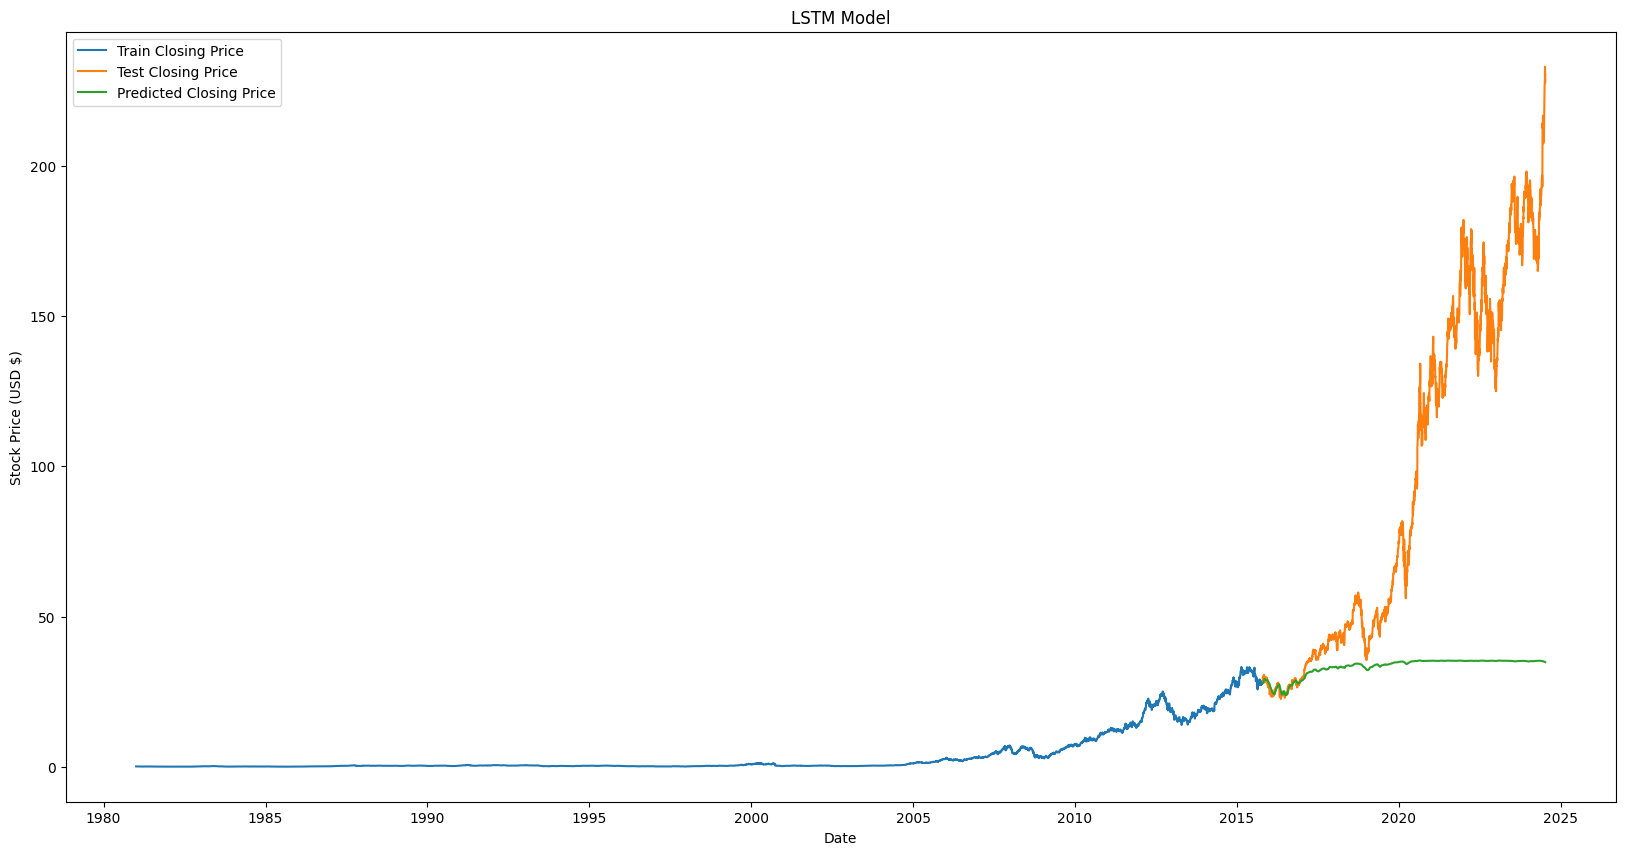

In [38]:
plot_stock_trend_lstm(train, test)

### Predicting Future Market

In [39]:
def preprocess_future_data(data, scaler, window_size, future_steps):
    raw = data["Close"][-window_size:].values
    raw = raw.reshape(-1, 1)
    raw = scaler.transform(raw)
    raw = raw.astype('float32')

    X_future = [raw]
    X_future = np.array(X_future)
    X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

    future_predictions = []

    for _ in range(future_steps):
        predicted = best_model.predict(X_future)[0][0]
        predicted_price = scaler.inverse_transform(np.array([[predicted]], dtype='float32'))[0][0]
        future_predictions.append(predicted_price)

        new_input = np.append(raw[1:], [[predicted]], axis=0)
        raw = new_input
        X_future = np.array([new_input])
        X_future = np.reshape(X_future, (X_future.shape[0], X_future.shape[1], 1))

    return future_predictions

In [40]:
# Predict the next 30 days
future_steps = 30
future_predictions = preprocess_future_data(data=stockPrices, scaler=scaler, window_size=window_size, future_steps=future_steps)

# Create a DataFrame for the future predictions
future_dates = pd.date_range(start=test.index[-1], periods=future_steps + 1, inclusive='right')
future_df = pd.DataFrame(data=future_predictions, index=future_dates, columns=['Predictions_lstm'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━

In [41]:
def plot_stock_trend_future(train, test, future_df):
    fig, ax = plt.subplots(figsize=(20, 10))
    ax.plot(train.index, train["Close"], label="Train Closing Price")
    ax.plot(test.index, test["Close"], label="Test Closing Price")
    ax.plot(test.index, test["Predictions_lstm"], label="Test Predictions Closing Price")
    ax.plot(future_df.index, future_df["Predictions_lstm"], label="Future Predictions Closing Price")
    ax.set_title("LSTM Model Future Predictions")
    ax.set_xlabel("Date")
    ax.set_ylabel("Stock Price (USD $)")
    ax.legend()
    plt.show()

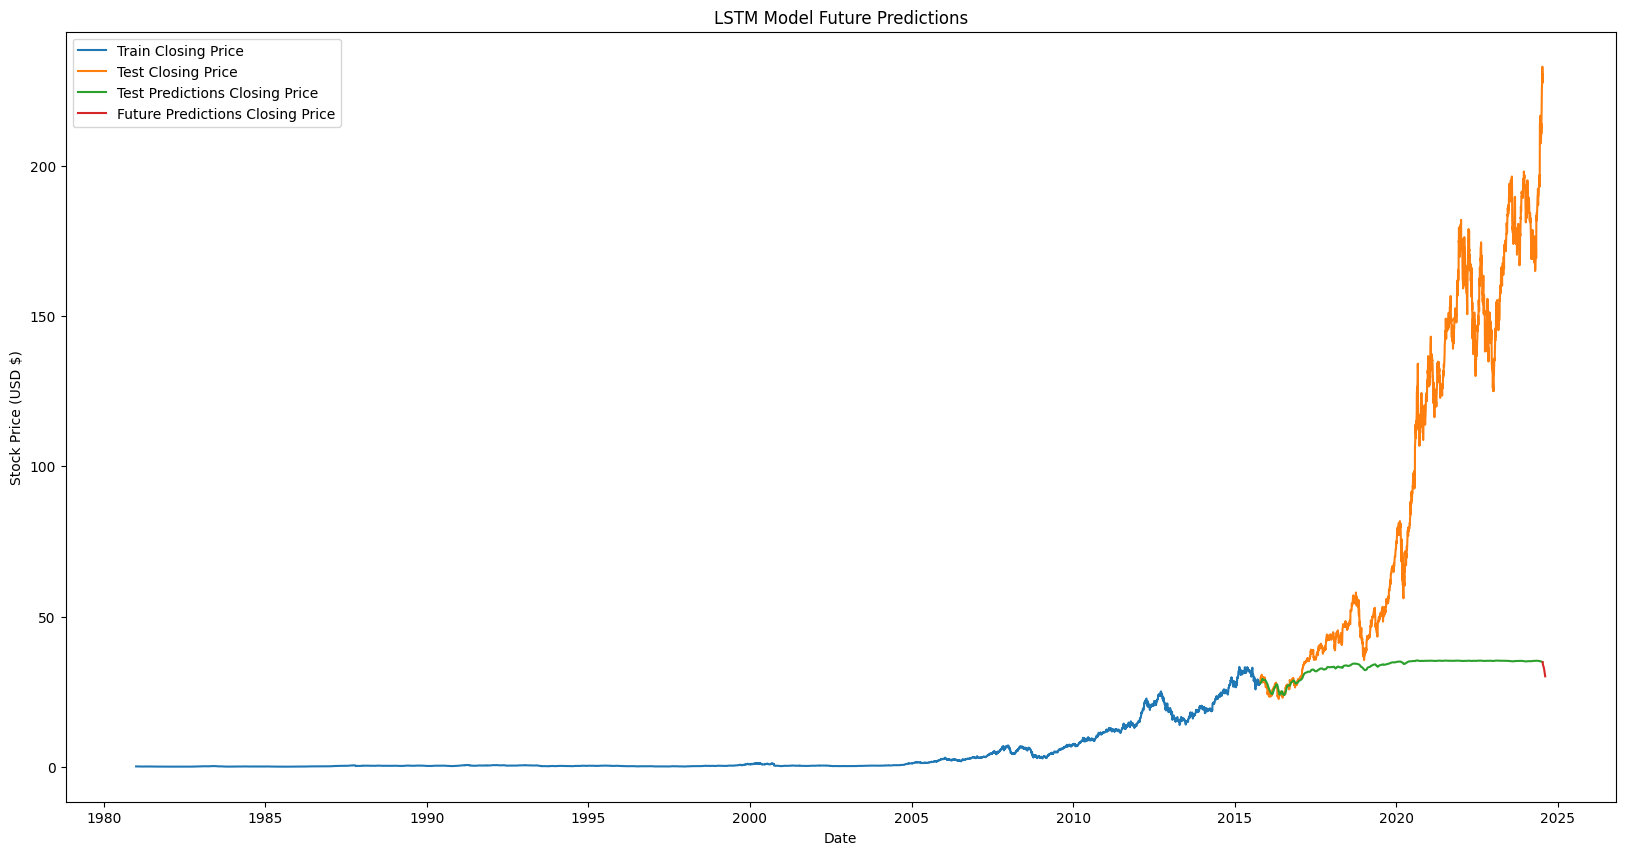

In [42]:
plot_stock_trend_future(train, test, future_df)